In [92]:
import numpy as np

import random
import h5py
import scipy.io.wavfile as sciwav

import os
import random
import time
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = "Symbola"
matplotlib.rcParams['font.size'] = 12
import glob

import operator
import math
import re

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

In [93]:
import theano.tensor as T
import theano

# Activation Functions and Derivatives

In [94]:
matplotlib.matplotlib_fname()

u'/usr/local/lib/python2.7/dist-packages/matplotlib/mpl-data/matplotlibrc'

In [95]:
def activation_plot(fnc, xscl = 4.0, fnc_yscl = None, grd_yscl = None, marker = '.',
                    main_title = None):
    plt.close('all')
    
    grd = T.grad(fnc, x)
    function = theano.function([x], fnc)
    gradient = theano.function([x], grd)
    
    if (type(xscl) is tuple):
        x_lower = xscl[0]
        x_upper = xscl[1]
    else:
        x_lower = -xscl
        x_upper = xscl
    x_vals = np.arange(x_lower, x_upper, 0.0005)
    
    plt.figure(figsize = (10, 4))

    plt.subplot(121)
    plt.title('function')
    plt.grid()
    plt.axhline(0, color='gray', linewidth = 2)
    plt.axvline(0, color='gray', linewidth = 2)
    plt.xlim(x_lower, x_upper)
    if (fnc_yscl):
        plt.ylim(fnc_yscl[0], fnc_yscl[1])
    plt.plot(x_vals, [function(i) for i in x_vals], marker, ms = 3)

    plt.subplot(122)
    plt.title('derivative')
    plt.grid()
    plt.axhline(0, color='gray', linewidth = 2)
    plt.axvline(0, color='gray', linewidth = 2)
    plt.xlim(x_lower, x_upper)
    if (grd_yscl):
        plt.ylim(grd_yscl[0], grd_yscl[1])
    plt.plot(x_vals, [gradient(i) for i in x_vals], marker, ms = 3)

    if (main_title):
        plt.suptitle(main_title)
    
    plt.show()
    
x = T.dscalar()

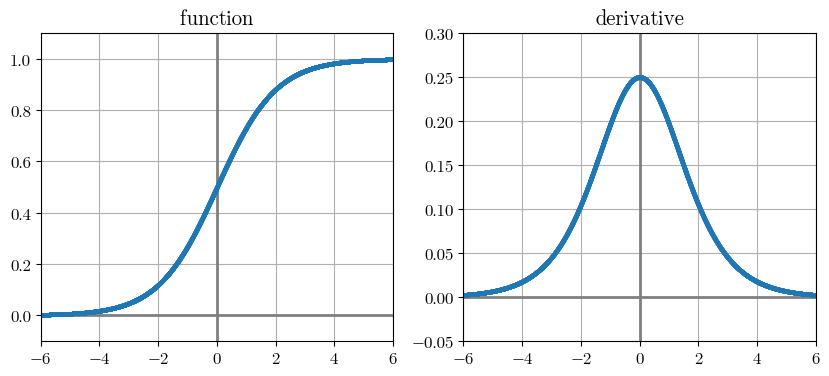

In [96]:
# sigmoid
fnc = 1 / (1 + T.exp(-x))
activation_plot(fnc, 6.0, (-0.1, 1.1), (-0.05, 0.3))

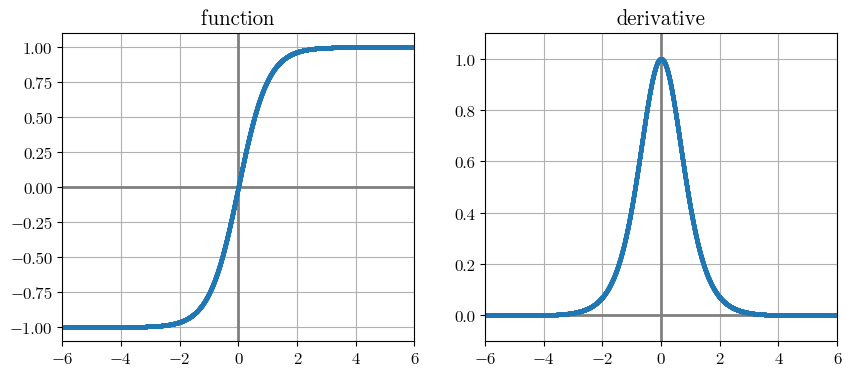

In [97]:
# tanh
fnc = T.tanh(x)
activation_plot(fnc, 6.0, (-1.1, 1.1), (-0.1, 1.1))

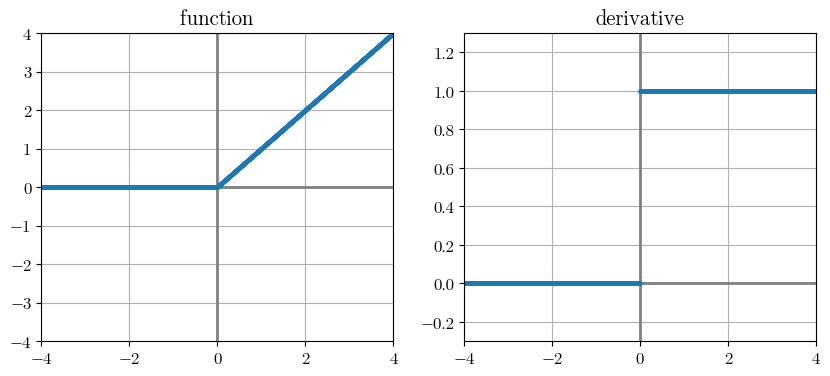

In [98]:
# ReLU
fnc = T.switch(x < 0, 0, x)
activation_plot(fnc, 4.0, (-4.0, 4.0), (-0.3, 1.3))

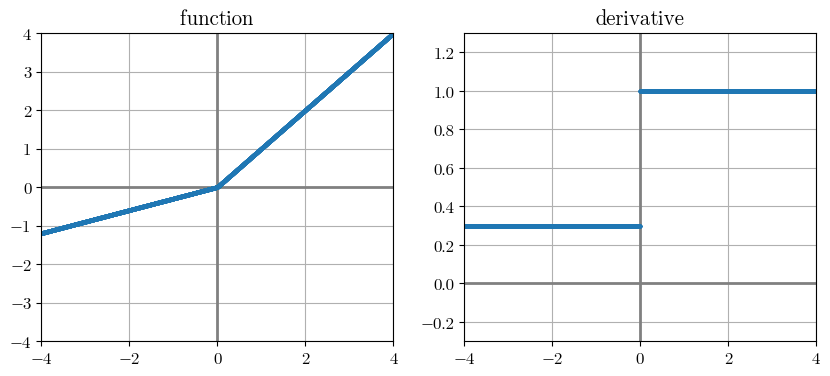

In [99]:
# Leaky ReLU
fnc = T.switch(x < 0, 0.3 * x, x)
activation_plot(fnc, 4.0, (-4.0, 4.0), (-0.3, 1.3))

# Visualizing Softmax

TO QUANTIZE: [ 0.4]


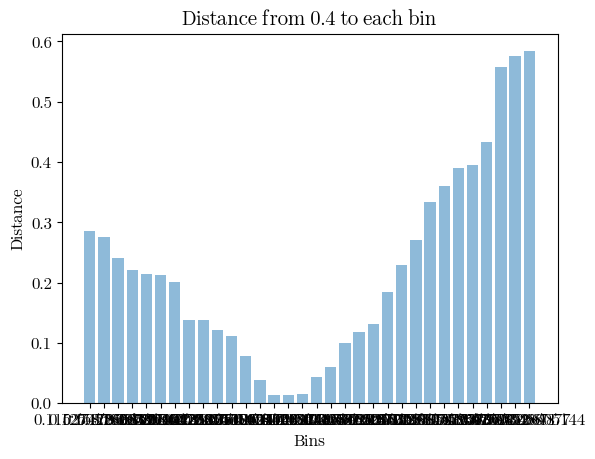

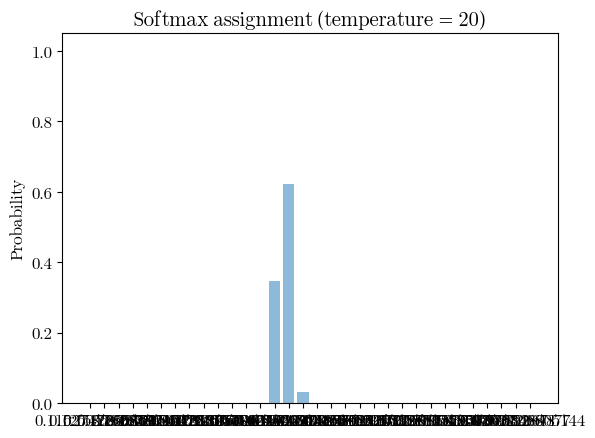

PROBS [  7.00902264e-119   1.24355281e-114   4.99195178e-100   2.15818188e-091
   1.72250353e-088   2.22254744e-087   1.95924334e-082   3.49191815e-055
   3.78937330e-055   3.72828923e-048   8.55261789e-044   1.55403338e-029
   4.74902366e-012   3.46599325e-001   6.21290876e-001   3.21097983e-002
   5.34770862e-014   5.48899542e-021   1.67417027e-038   1.21099120e-046
   2.01449142e-052   3.00747057e-075   1.83522065e-094   1.39936390e-112
   9.14041552e-140   1.20192057e-151   2.07707103e-164   2.17253603e-166
   5.30004053e-183   2.76983814e-237   2.04093579e-245   1.17098285e-248]
BINS: [ 0.11527423  0.12505793  0.15868397  0.17856868  0.18525095  0.18780841
  0.19919524  0.26194293  0.26202468  0.27812652  0.28816715  0.32100054
  0.36126157  0.38627507  0.4131413   0.41610394  0.44322487  0.45931689
  0.49964826  0.51839282  0.5316994   0.58425813  0.62850118  0.67021886
  0.73281455  0.76017177  0.78955834  0.79411858  0.8323707   0.95735922
  0.97608528  0.98354861]
QUANTIZED: 0

In [100]:
def numpy_softmax(x):
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis = -1, keepdims = True)

codebook = np.sort(np.random.uniform(0.0, 1.0, 32))
to_quantize = np.array([0.4]).astype('float')

distances = np.abs(codebook - to_quantize)

print "TO QUANTIZE:", to_quantize

labels = tuple([str(i) for i in codebook])
y_pos = np.arange(len(labels))

plt.bar(y_pos, distances, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Distance')
plt.xlabel('Bins')
plt.title('Distance from 0.4 to each bin')
plt.show()

SOFTMAX_TEMP = 1000.0
probs = numpy_softmax(SOFTMAX_TEMP * -distances)
plt.bar(y_pos, probs, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylim(0.0, 1.05)
plt.ylabel('Probability')
plt.title('Softmax assignment (temperature = 20)')
plt.show()
print "PROBS", probs
print "BINS:", codebook

print "QUANTIZED:", np.dot(codebook, probs)

In [101]:
x = T.dscalar()

codebook = np.linspace(0.0, 1.0, 32)
print codebook
codebook = theano.shared(codebook)

[ 0.          0.03225806  0.06451613  0.09677419  0.12903226  0.16129032
  0.19354839  0.22580645  0.25806452  0.29032258  0.32258065  0.35483871
  0.38709677  0.41935484  0.4516129   0.48387097  0.51612903  0.5483871
  0.58064516  0.61290323  0.64516129  0.67741935  0.70967742  0.74193548
  0.77419355  0.80645161  0.83870968  0.87096774  0.90322581  0.93548387
  0.96774194  1.        ]


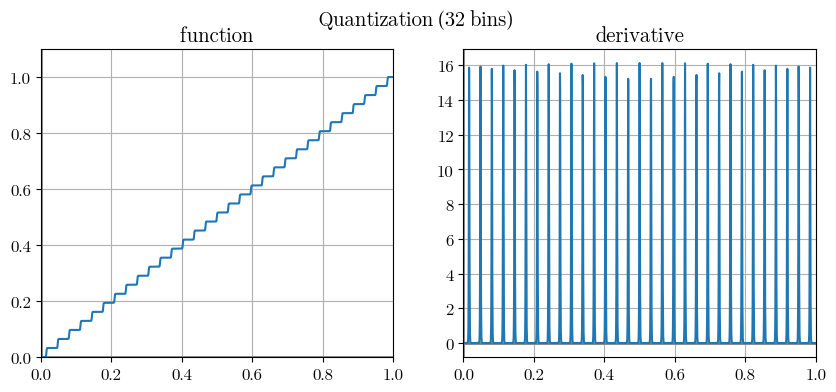

In [102]:
# i cheated and edited this one after exporting
temp = 1000
distances = T.abs_(T.reshape(x, (-1, 1)) - codebook)
probs = T.nnet.softmax(temp * -distances)
fnc = T.dot(probs, codebook)[0]

title = 'Quantization (32 bins)'

activation_plot(fnc, (0.0, 1.0), (0.0, 1.1), None, marker = '', main_title = title)

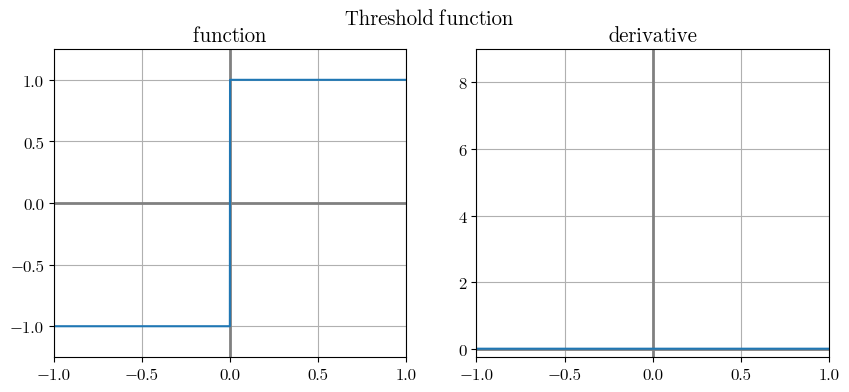

In [116]:
# i cheated and edited this one after exporting
#temp = 1000
#distances = T.abs_(T.reshape(x, (-1, 1)) - codebook)
#probs = T.nnet.softmax(temp * -distances)
#fnc = T.dot(probs, codebook)[0]
fnc = T.sgn(x)

title = 'Threshold function'

activation_plot(fnc, (-1.0, 1.0), (-1.25, 1.25), (-0.25, 9.0), marker = '', main_title = title)

In [317]:
x = T.dscalar()

codebook = np.linspace(0.0, 1.0, 32)
print codebook
codebook = theano.shared(codebook)

[ 0.          0.03225806  0.06451613  0.09677419  0.12903226  0.16129032
  0.19354839  0.22580645  0.25806452  0.29032258  0.32258065  0.35483871
  0.38709677  0.41935484  0.4516129   0.48387097  0.51612903  0.5483871
  0.58064516  0.61290323  0.64516129  0.67741935  0.70967742  0.74193548
  0.77419355  0.80645161  0.83870968  0.87096774  0.90322581  0.93548387
  0.96774194  1.        ]


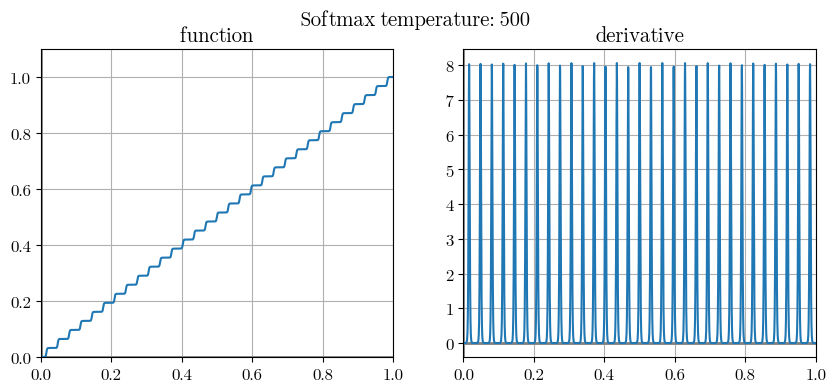

In [318]:
temp = 500
distances = T.abs_(T.reshape(x, (-1, 1)) - codebook)
probs = T.nnet.softmax(temp * -distances)
fnc = T.dot(probs, codebook)[0]

title = 'Softmax temperature: ' + str(temp)

activation_plot(fnc, (0.0, 1.0), (0.0, 1.1), None, marker = '', main_title = title)

# Mel filterbanks

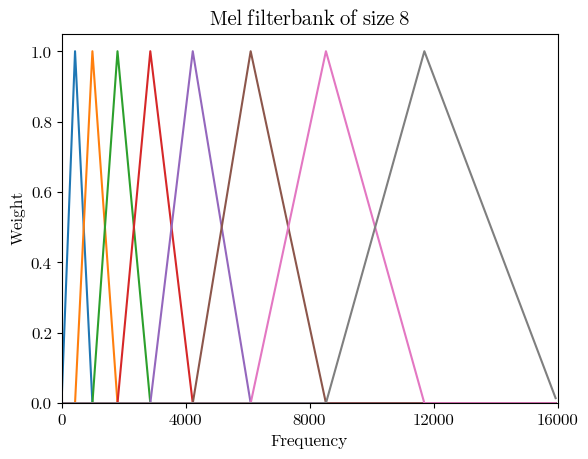

In [78]:
from perceptual_loss import *

mel_filters = melFilterBank(8, 512).transpose()

for i in xrange(0, 8):
    plt.plot(mel_filters[:, i])
plt.xticks([0, 0.25 * 257, 0.5 * 257, 0.75 * 257, 257], [0, 4000, 8000, 12000, 16000])
plt.xlabel('Frequency')
plt.xlim(0, 257)
plt.ylabel('Weight')
plt.ylim(0.0, 1.05)
plt.title('Mel filterbank of size 8')
plt.show()

# Coder vs. AMR-WB

In [158]:
amr_bitrates = [8.85, 15.85, 19.85, 23.85]
our_bitrates = [9.06, 15.93, 19.87, 23.71]

def plot_quality_comparison(amr_quality, our_quality,
                            quality_label = "PESQ score",
                            title = None):
    plt.plot(amr_bitrates, amr_quality, '-o')
    plt.plot(our_bitrates, our_quality, '-o')
    
    plt.xlabel('Bitrate')
    plt.ylabel(quality_label)
    plt.legend(['AMR-WB', 'Our approach'])
    
    if (title):
        plt.title(title)
    
    plt.grid()
    plt.show()

## Objective tests

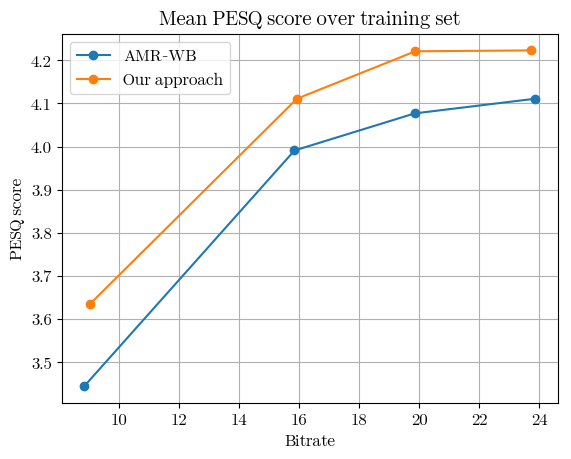

In [159]:
train_amr_pesq = [3.444, 3.991, 4.077, 4.111]
train_our_pesq = [3.636, 4.111, 4.221, 4.223]

plot_quality_comparison(train_amr_pesq, train_our_pesq,
                        title = 'Mean PESQ score over training set')

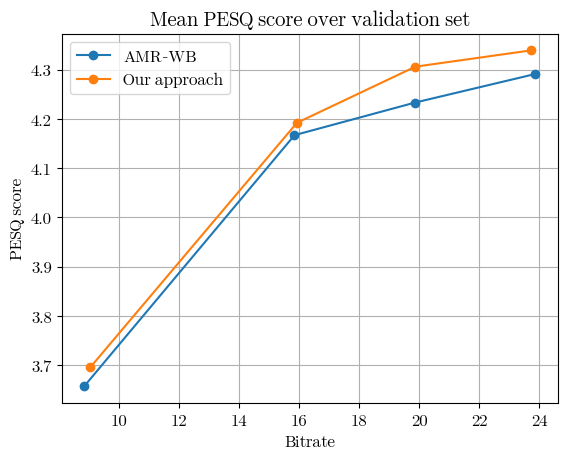

In [165]:
val_amr_pesq = [3.657, 4.167, 4.233, 4.291]
val_our_pesq = [3.696, 4.192, 4.306, 4.339]

plot_quality_comparison(val_amr_pesq, val_our_pesq,
                        title = 'Mean PESQ score over validation set')

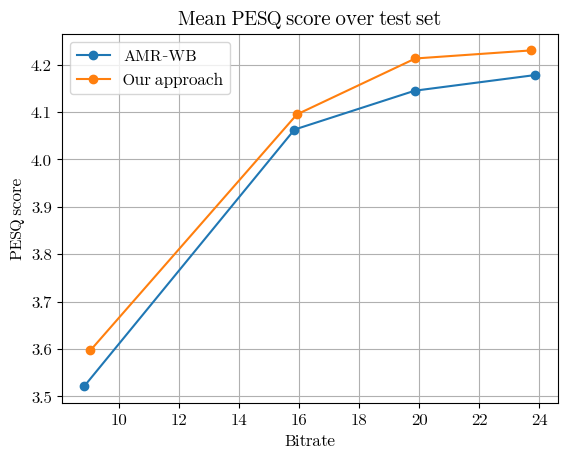

In [167]:
test_amr_pesq = [3.521, 4.063, 4.145, 4.178]
test_our_pesq = [3.597, 4.095, 4.213, 4.23]

plot_quality_comparison(test_amr_pesq, test_our_pesq,
                        title = 'Mean PESQ score over test set')